# Neural Process example implementation for Mixture Density Learning

In [6]:
# %load_ext autoreload
# %autoreload 2

In [7]:
from typing import Callable, Sequence, Any
from functools import partial

import jax
import jax.numpy as jnp

from torch.utils.data import Dataset
from torch.utils.data import Subset

import numpy as np

import flax
import flax.linen as nn

import optax
import jaxopt

import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import DataLoader

from functions import Fourier, Mixture, Slope, Polynomial, WhiteNoise, Shift
from networks import MixtureNeuralProcess, MLP, MeanAggregator, SequenceAggregator, NonLinearMVN, ResBlock
#from dataloader import MixtureDataset

from jax.tree_util import tree_map
from torch.utils import data

rng = jax.random.key(0)
print('cuda?', jax.devices(), jax.devices()[0].device_kind)

cuda? [CpuDevice(id=0)] cpu


In [8]:
# Test-configuration
dataset_size = 100
test_resolution = 500

In [9]:
# Train-configuration
num_posterior_mc = 10  # number of latents to sample from p(Z | X, Y)
batch_size = 256  # number of functions to sample from p(Z)

kl_penalty = 1e-4  # Note to self: magnitude of the kl-divergence can take over in the loss
num_target_samples = 128
num_context_samples = 256

In [10]:
class NumpyLoader(data.DataLoader):
  def __init__(self, dataset, batch_size=1,
                shuffle=False, sampler=None,
                batch_sampler=None, num_workers=0,
                pin_memory=False, drop_last=False,
                timeout=0, worker_init_fn=None):
    super(self.__class__, self).__init__(dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        sampler=sampler,
        batch_sampler=batch_sampler,
        num_workers=num_workers,
        collate_fn=numpy_collate,
        pin_memory=pin_memory,
        drop_last=drop_last,
        timeout=timeout,
        worker_init_fn=worker_init_fn)

class FlattenAndCast(object):
  def __call__(self, pic):
    return np.ravel(np.array(pic, dtype=jnp.float32))

## Define Training Distribution/ Data-Generation

In [11]:
f1 = Fourier(n=4, amplitude=.5, period=1.0)
f2 = Fourier(n=2, amplitude=.5, period=1.0)
f3 = Fourier(n=6, amplitude=.5, period=2.0)
f4 = Fourier(n=3, amplitude=1.0, period=2.0)

m = Mixture([Shift(f1, y_shift=-2), Shift(f2, y_shift=0.0), Shift(f3, y_shift=2)])
nm = Mixture([WhiteNoise(m.branches[0], 0.05), WhiteNoise(m.branches[1], 0.2), WhiteNoise(m.branches[2], 0.1)])

rng = jax.random.key(0)

In [12]:
### Define joint-sampler

def joint(
    module: nn.Module, 
    data_sampler: Callable[
        [nn.Module, flax.typing.VariableDict, flax.typing.PRNGKey], 
        tuple[jax.Array, jax.Array]
    ],
    key: flax.typing.PRNGKey, 
    return_params: bool = False
) -> tuple[jax.Array, jax.Array]:
    # Samples from p(Z, X, Y)
    key_param, key_rng, key_data = jax.random.split(key, 3)
    
    params = module.init({'param': key_param, 'default': key_rng}, jnp.zeros(()))
    xs, ys = data_sampler(module, params, key_data)

    if return_params:
        return xs, ys, params
    return xs, ys


def uniform(
    module: nn.Module, 
    params: flax.typing.VariableDict, 
    key: flax.typing.PRNGKey, 
    n: int,
    bounds: tuple[float, float]
) -> tuple[jax.Array, jax.Array]:
    
    # Samples from p(X, Y | Z) = p(Y | Z, X)p(X)
    key_xs, key_ys = jax.random.split(key)
    xs = jax.random.uniform(key_xs, (n,)) * (bounds[1] - bounds[0]) + bounds[0]

    ys = jax.vmap(module.apply, in_axes=(None, 0))(params, xs, rngs={'default': jax.random.split(key_ys, n)})

    return xs, ys

In [13]:
class MixtureDataset(Dataset):
    def __init__(self, dataset_size, key, num_context_samples, num_target_samples, sampler):
        self.key = key
        self.dataset_size = dataset_size
        self.num_context_samples = num_context_samples
        self.num_target_samples = num_target_samples
        self.sampler = sampler
        self.context_xs, self.target_xs, self.context_ys, self.target_ys = self._get_data()
        
    def __len__(self):
        return self.dataset_size

    def __getitem__(self, idx):
        return self.context_xs[idx], self.context_ys[idx], self.target_xs[idx], self.target_ys[idx]

    def _get_data(self):
        key_data, self.key = jax.random.split(self.key)
        xs, ys = jax.vmap(self.sampler)(jax.random.split(key_data, num=self.dataset_size))
        xs, ys = xs[..., None], ys[..., None]
        # Split into context- and target-points.
        X, x_test = jnp.split(xs, indices_or_sections=(num_context_samples, ), axis=1)
        y, y_test = jnp.split(ys, indices_or_sections=(num_context_samples, ), axis=1)
        return X, x_test, y, y_test

In [15]:
# Specify which function-prior to learn
data_sampler = partial(
    joint, 
    Mixture([WhiteNoise(Shift(f2, y_shift=1.0), 0.05), WhiteNoise(Shift(f4, y_shift=-1.0), 0.2)]), 
    partial(uniform, n=num_target_samples + num_context_samples, bounds=(-1, 1))
)

rng, key = jax.random.split(rng)
# xs, ys = data_sampler(key)

# X, x_target = jnp.split(xs, indices_or_sections=(num_context_samples, ))
# y, y_target = jnp.split(ys, indices_or_sections=(num_context_samples, ))
# 
# sns.jointplot(x=xs, y=ys)
# sns.scatterplot(x=x_target, y=y_target, color='red')  # prediction targets

def numpy_collate(batch):
    transposed_data = list(zip(*batch))
    xs_context = np.array(transposed_data[0])
    ys_context = np.array(transposed_data[1])
    xs_target = np.array(transposed_data[2])
    ys_target = np.array(transposed_data[3])
    return xs_context, ys_context, xs_target, ys_target
#rng, key = jax.random.split(rng)

dataset = MixtureDataset(dataset_size=, key=key, num_context_samples=256, num_target_samples=128, sampler=data_sampler)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True, collate_fn=numpy_collate)
data_iter = iter(dataloader)
x_context, y_context, x_target, y_target = next(iter(dataloader))
print(x_context.shape)
print(y_context.shape)
print(x_target.shape)
print(y_target.shape)
print(dataset.__len__())


(1, 256, 1)
(1, 256, 1)
(1, 128, 1)
(1, 128, 1)
1


## Define Test-Case

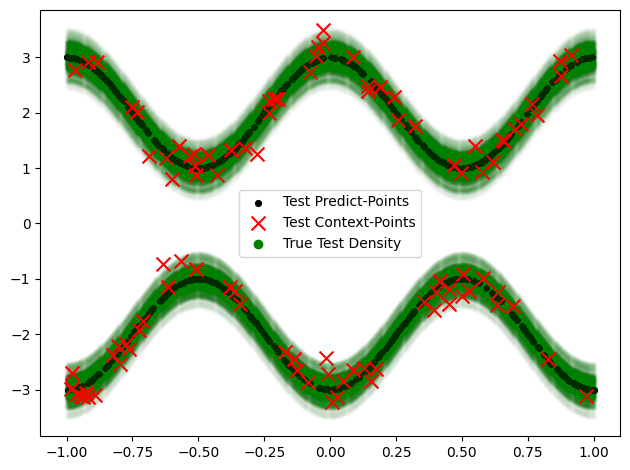

In [24]:

def f(
    key: flax.typing.PRNGKey, 
    x: jax.Array, 
    noise_scale: float = 0.2, 
    mixture_prob: float = 0.5, 
    corrupt: bool = True
):
    key_noise, key_mixture = jax.random.split(key)
    
    noise = jax.random.normal(key, x.shape) * noise_scale
    choice = jax.random.bernoulli(key_mixture, mixture_prob, x.shape)

    # return choice * (jnp.sin(2 * jnp.pi * x / 2)) + (1 - choice) * (jnp.cos(2 * jnp.pi * 2 * x)) + corrupt * noise
    return choice * (-2-jnp.cos(2 * jnp.pi * x)) + (1 - choice) * (2+jnp.cos(2 * jnp.pi * x)) + corrupt * noise


rng, key_data, key_test, key_x = jax.random.split(rng, 4)

keys_data = jax.random.split(key_data, (dataset_size,))
keys_test = jax.random.split(key_test, (test_resolution,))

xs = jax.random.uniform(key_x, (dataset_size,)) * 2 - 1
ys = jax.vmap(f)(keys_data, xs)

x_test = jnp.linspace(-1, 1, test_resolution)
y_test = jax.vmap(partial(f, corrupt=False))(keys_test, x_test)

# Repeat the random keys for each x-point. Roughly gives an idea of the spread
y_test_samples = jax.vmap(jax.vmap(
    partial(f, corrupt=True), in_axes=(0, None)), in_axes=(None, 0))(keys_test, x_test)

# True Function
plt.scatter(x_test, y_test, c='black', s=10, marker='o', linewidth=2, label='Test Predict-Points')
plt.scatter(
    jnp.broadcast_to(x_test, y_test_samples.shape).T, 
    y_test_samples, c='green', s=5, marker='o', linewidth=2, alpha=0.01,
)
plt.scatter(xs, ys, c='red', marker='x', s=100, label='Test Context-Points')

plt.scatter([], [], c='green', marker='o', label='True Test Density')
plt.legend()

plt.tight_layout()
plt.show()

# Define the Model

In [25]:
# Construct the NP model

embedding_xs = MLP([64, 64], activation=jax.nn.leaky_relu, activate_final=True, use_layernorm=True)
embedding_ys = MLP([64, 64], activation=jax.nn.leaky_relu, activate_final=True, use_layernorm=True)
embedding_both = MLP([64, 64], activation=jax.nn.leaky_relu, activate_final=True, use_layernorm=True)

projection_posterior = NonLinearMVN(MLP([128, 64], activation=jax.nn.leaky_relu, activate_final=False, use_layernorm=True))

output_model = nn.Sequential([
    ResBlock(
        MLP([128, 128], activation=jax.nn.leaky_relu, activate_final=True, use_layernorm=True),
    ),
    ResBlock(
        MLP([128, 128], activation=jax.nn.leaky_relu, activate_final=True, use_layernorm=True),
    ),
    nn.Dense(2)
])
# output_model = MLP([128, 128, 2], activation=jax.nn.leaky_relu, activate_final=False, use_layernorm=True)
projection_outputs = NonLinearMVN(output_model)

posterior_aggregator = MeanAggregator(projection_posterior)
# posterior_aggregator = SequenceAggregator(projection_posterior)

model = MixtureNeuralProcess(
    embedding_xs, embedding_ys, embedding_both, 
    posterior_aggregator, 
    projection_outputs
)

rng, key = jax.random.split(rng)
params = model.init({'params': key, 'default': key}, xs[:, None], ys[:, None], xs[:3, None])
print('params-shape', jax.tree_map(jnp.shape, params))

params-shape {'params': {'embed_both': {'Dense_0': {'bias': (64,), 'kernel': (128, 64)}, 'Dense_1': {'bias': (64,), 'kernel': (64, 64)}, 'LayerNorm_0': {'bias': (64,), 'scale': (64,)}, 'LayerNorm_1': {'bias': (64,), 'scale': (64,)}}, 'embed_xs': {'Dense_0': {'bias': (64,), 'kernel': (1, 64)}, 'Dense_1': {'bias': (64,), 'kernel': (64, 64)}, 'LayerNorm_0': {'bias': (64,), 'scale': (64,)}, 'LayerNorm_1': {'bias': (64,), 'scale': (64,)}}, 'embed_ys': {'Dense_0': {'bias': (64,), 'kernel': (1, 64)}, 'Dense_1': {'bias': (64,), 'kernel': (64, 64)}, 'LayerNorm_0': {'bias': (64,), 'scale': (64,)}, 'LayerNorm_1': {'bias': (64,), 'scale': (64,)}}, 'likelihood': {'projection': {'layers_0': {'LayerNorm_0': {'bias': (128,), 'scale': (128,)}, 'module': {'Dense_0': {'bias': (128,), 'kernel': (128, 128)}, 'Dense_1': {'bias': (128,), 'kernel': (128, 128)}, 'LayerNorm_0': {'bias': (128,), 'scale': (128,)}, 'LayerNorm_1': {'bias': (128,), 'scale': (128,)}}}, 'layers_1': {'LayerNorm_0': {'bias': (128,), 'sc

/tmp/ipykernel_11842/2886687022.py:32: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  print('params-shape', jax.tree_map(jnp.shape, params))


### Test-predictions at init

In [26]:
means, stds = model.apply(
    params, 
    xs[:, None], ys[:, None], x_test[:, None], 
    k=15,
    rngs={'default': jax.random.key(0)}
)
print('prediction-shape', means.shape, stds.shape)  # dim: (len(x_test), k, 1)

prediction-shape (500, 15, 1) (500, 15, 1)


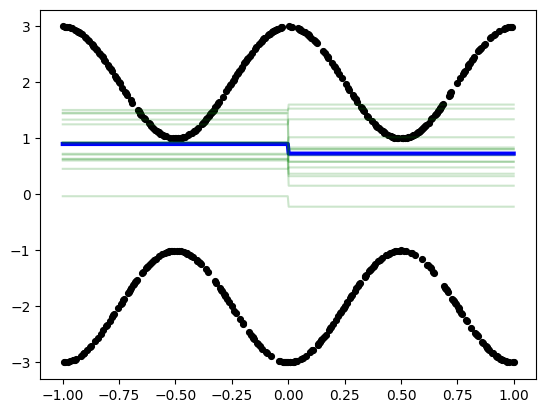

In [27]:
# Example predictions at init
plt.plot(x_test, means.mean(axis=(-2, -1)), color='blue', linewidth=3)  # Mixture-mean

for i in range(means.shape[1]):
    plt.plot(x_test, means[:, i], color='green', alpha=0.2)  # Mixture-components

plt.scatter(x_test, y_test, c='black', s=10, marker='o', linewidth=2, label='Test Predict-Points')

# Dummy Optimization/ Amortization procedure

In [28]:
# Define how the model loss should be computed

def posterior_loss(
    params: flax.typing.VariableDict,
    batch,
    key: flax.typing.PRNGKey,
    sampling_fun: Callable[
        [flax.typing.PRNGKey], 
        tuple[jax.Array, jax.Array]
    ] = data_sampler
):
    key_data, key_model = jax.random.split(key)
    X = batch[0]
    y = batch[1]
    x_test = batch[2]
    y_test = batch[3]
    # Compute ELBO over batch of datasets
    elbos = jax.vmap(partial(
        model.apply, 
        params, 
        beta=kl_penalty, k=num_posterior_mc, 
        method=model.elbo
    ))(
        X, y, x_test, y_test, rngs={'default': jax.random.split(key_model, X.shape[0])}
    )
    
    return -elbos.mean()


def posterior_loss_filtered(
    params: flax.typing.VariableDict,
    key: flax.typing.PRNGKey,
    sampling_fun: Callable[
        [flax.typing.PRNGKey], 
        tuple[jax.Array, jax.Array]
    ] = data_sampler
):
    # Sample datasets from p(X, Y, Z)
    key_data, key_model = jax.random.split(key)
    xs, ys = jax.vmap(data_sampler)(jax.random.split(key_data, num=batch_size))
    xs, ys = xs[..., None], ys[..., None]
    
    # Split into context- and target-points.
    X, x_test = jnp.split(xs, indices_or_sections=(num_context_samples, ), axis=1)
    y, y_test = jnp.split(ys, indices_or_sections=(num_context_samples, ), axis=1)

    # Compute ELBO over batch of datasets
    elbos = jax.vmap(partial(
        model.apply, 
        params, 
        beta=kl_penalty, k=num_posterior_mc, 
        method=model.elbo
    ))(
        X, y, x_test, y_test, rngs={'default': jax.random.split(key_model, num=batch_size)}
    )

    # Mask out all samples with higher data-likelihood than the worst 40%
    q40 = jnp.percentile(elbos, 40)
    mask = elbos <= q40
    
    return -(elbos * mask / mask.sum()).sum()


In [29]:
@jax.jit
def step(
    theta: flax.typing.VariableDict, 
    opt_state: optax.OptState,
    current_batch,
    random_key: flax.typing.PRNGKey
) -> tuple[flax.typing.VariableDict, optax.OptState, jax.Array]:
    # Implements a generic SGD Step
    
    # value, grad = jax.value_and_grad(posterior_loss_filtered, argnums=0)(theta, random_key)
    value, grad = jax.value_and_grad(posterior_loss, argnums=0)(theta, current_batch, random_key)
    
    updates, opt_state = optimizer.update(grad, opt_state, theta)
    theta = optax.apply_updates(theta, updates)
    
    return theta, opt_state, value


In [68]:
# Initialize the Optimization.
rng, key = jax.random.split(rng)

last_key = key
print(last_key)

params = params0 = model.init(
    {'params': key, 'default': key}, 
    xs[:, None], ys[:, None], x_test[:1, None]
)

optimizer = optax.chain(
    optax.clip(.1),
    optax.clip_by_global_norm(1.0),
    optax.adamw(learning_rate=1e-3, weight_decay=1e-6),
)
opt_state = optimizer.init(params)

best, best_params = jnp.inf, params
losses = list()
for i in (pbar := tqdm.trange(10, desc='Optimizing params. ')):
    
    rng, key = jax.random.split(rng)
    batch = next(data_iter)
    x_context, y_context, x_target, y_target = next(iter(dataloader))
    params_new, opt_state, loss = step(params, opt_state, (x_context, y_context, x_target, y_target), key)

    losses.append(loss)

    if loss < best:
        best = loss
        best_params = params_new
    
    if jnp.isnan(loss):
        break
    else:
        params = params_new
    
    pbar.set_description(f'Optimizing params. Loss: {loss:.4f}')

params = best_params

Array((), dtype=key<fry>) overlaying:
[1153760980 3446263651]


Optimizing params. Loss: 1.6401: 100%|██████████| 10/10 [00:27<00:00,  2.77s/it]


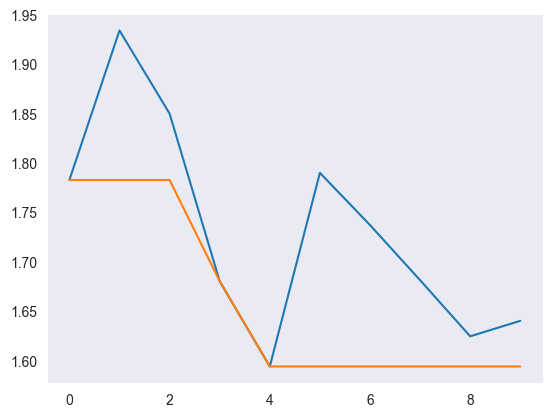

In [69]:
plt.plot(losses)
plt.plot(jnp.ufunc(jnp.minimum, nin=2, nout=1).accumulate(jnp.asarray(losses)))
plt.grid()
# plt.xlim([10, len(losses)])
# plt.ylim([0, 3])

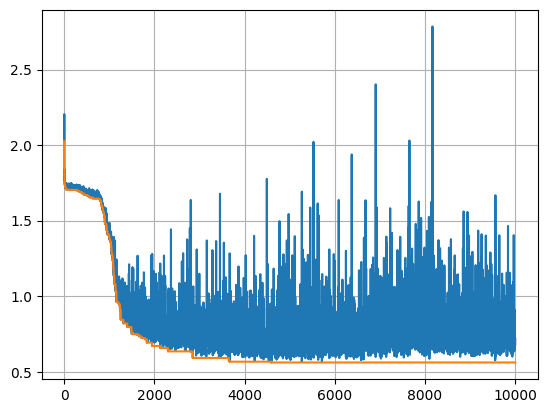

In [15]:
# Using q40 filtering

plt.plot(losses)
plt.plot(jnp.ufunc(jnp.minimum, nin=2, nout=1).accumulate(jnp.asarray(losses)))
plt.grid()
# plt.xlim([10, len(losses)])
# plt.ylim([0, 3])

# Test-predictions after training

In [44]:
# Test predictions on functions from the training-distribution
rng, key = jax.random.split(rng)

x_train, y_train = data_sampler(key)
x_train, y_train = x_train[..., None], y_train[..., None]

# Split into context- and target-points.
X, x_predict_train = jnp.split(x_train, indices_or_sections=(num_context_samples, ))
y, y_predict_train = jnp.split(y_train, indices_or_sections=(num_context_samples, ))

# Compute ELBO over batch of datasets
means, stds = model.apply(
    params, 
    X, y, x_test[..., None],
    k=10,
    rngs={'default': jax.random.key(0)}
)
print('prediction-shape', means.shape, stds.shape)  # dim: (len(x_test), k, 1)

prediction-shape (500, 10, 1) (500, 10, 1)


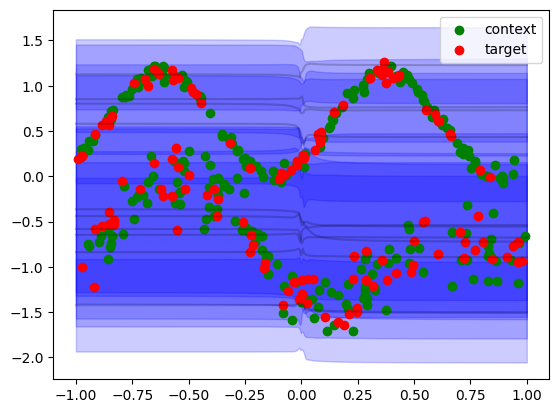

In [47]:
# plt.plot(x_test, means.mean(axis=(-2, -1)), label='predict', color='blue')
# plt.fill_between(
#     x_test,
#     means.mean(axis=(-2, -1)) + stds.mean(axis=(-2, -1)),
#     means.mean(axis=(-2, -1)) - stds.mean(axis=(-2, -1)),
#     color='blue', alpha=0.2
# )

for i in range(means.shape[1]):
    plt.plot(x_test, means[:, i], color='black', alpha=0.2)  # Mixture-components
    plt.fill_between(
        x_test,
        means[:, i, 0] + stds[:, i, 0],
        means[:, i, 0] - stds[:, i, 0],
        color='blue', alpha=0.2
    )

plt.scatter(X, y, color='green', label='context')
plt.scatter(x_predict_train, y_predict_train, color='red', label='target')

plt.legend()

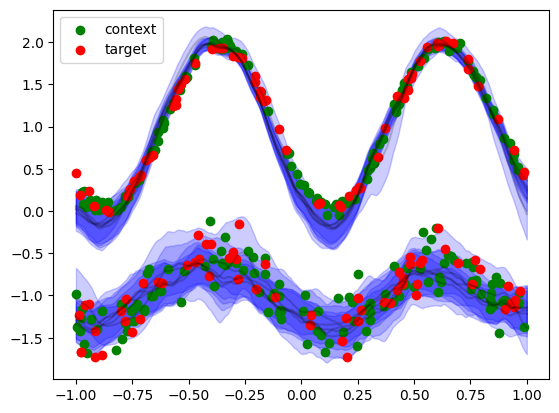

In [17]:
# Using q40 filtering

# plt.plot(x_test, means.mean(axis=(-2, -1)), label='predict', color='blue')
# plt.fill_between(
#     x_test,
#     means.mean(axis=(-2, -1)) + stds.mean(axis=(-2, -1)),
#     means.mean(axis=(-2, -1)) - stds.mean(axis=(-2, -1)),
#     color='blue', alpha=0.2
# )

for i in range(means.shape[1]):
    plt.plot(x_test, means[:, i], color='black', alpha=0.2)  # Mixture-components
    plt.fill_between(
        x_test,
        means[:, i, 0] + stds[:, i, 0],
        means[:, i, 0] - stds[:, i, 0],
        color='blue', alpha=0.2
    )

plt.scatter(X, y, color='green', label='context')
plt.scatter(x_predict_train, y_predict_train, color='red', label='target')

plt.legend()

In [41]:
# Lets setup the spl for a very small example so we can debug and make sure it would work on a basic level

# We have to setup the dataset + dataloader
# Create a SPL_curricula class to encapsulate a dataset, and the ordering , pacing logic
# For now lets hard code, the hard weight variant, with a linear pacing function, understood as portion of data being sampled
def numpy_collate(batch):
    transposed_data = list(zip(*batch))
    xs_context = np.array(transposed_data[0])
    ys_context = np.array(transposed_data[1])
    xs_target = np.array(transposed_data[2])
    ys_target = np.array(transposed_data[3])
    return xs_context, ys_context, xs_target, ys_target

class SPL_curriculum:
    def __init__(self, start_rate, growth_epochs, dataset, batch_size, rng):

        self.batch_size = batch_size
        self.start_rate = start_rate
        self.growth_epochs= growth_epochs 
        self.dataset = dataset
        self.rng = rng
    



    def data_curriculum(self, model, params, epoch):
        """ Use the model to calculate the loss for the whole dataset, 
        and then use the loss to calculate the SPL weights for the dataset
        based on the current schedule
        """

        # Calculating the expansion on the dataset based on the current schedule with linear increase.
        
        # Over how many epochs should the data_rate increase from start_rate to 1.0
        if(epoch == 0):
            data_rate = self.start_rate

        else:

            data_rate =  min(1.0 , self.start_rate + (1.0 - self.start_rate) / self.growth_epochs * epoch)

        
        curr_data_size = int(data_rate * self.dataset.__len__())
        print('curr_data_size', curr_data_size, "curr_data_rate", data_rate, "epoch number" , epoch) 
        sorted_indices = jnp.argsort(self.calculate_difficulty_ordering(model, params))[:curr_data_size]

        return DataLoader(Subset(self.dataset, sorted_indices), batch_size=self.batch_size, shuffle=True, collate_fn=numpy_collate)  # Maybe shuffle? 
        # calculate the loss over the dataset with the current model and params


    def calculate_difficulty_ordering(self, model, params):
        """ Calculate the difficulty of the dataset based on the model and params
        """
        # right now its not very extensible to other difficulty measure other than loss, maybe a function should be an input as well for difficulty calculation over a batch? 


        # Calculate the loss over the dataset with the current model and params
       # Have to do it in batches and then concatenate, create batches over the whole dataset
        losses = []
        self.rng, key_model = jax.random.split(self.rng) # might be problematic to always use the self.rng? if we reset it it should be reproducible i think

        for (X_b, y_b, x_test_b, y_test_b) in iter(DataLoader(self.dataset, batch_size=self.batch_size, shuffle=False, collate_fn=numpy_collate)):
            elbos = jax.vmap(partial(
                model.apply,
                params,
                beta=kl_penalty, k=num_posterior_mc,
                method=model.elbo
            ))(
                X_b, y_b, x_test_b, y_test_b, rngs={'default': jax.random.split(key_model, X_b.shape[0])}
            )
            losses.append(elbos)

        concatted_loss = jnp.concatenate(losses) # gonna be all in the gpu memory if available, so might be a problem , not sure how else to do it honestly. 
        return concatted_loss

    




In [35]:
dataset = MixtureDataset(dataset_size=256*5, key=key, num_context_samples=256, num_target_samples=128, sampler=data_sampler)
spl_curricula = SPL_curriculum(0.1, 10, dataset, 32, rng)




    

print(spl_curricula.dataset.__len__())
print(spl_curricula.calculate_difficulty_ordering(model, params).shape)
print(spl_curricula.data_curriculum(model, params, 1))

1280
(1280,)
curr_data_size 128 curr_data_rate 0.1 epoch number 1


TypeError: 'DataLoader' object is not callable

In [42]:
# Lets setup the training loop with the SPL_curricula 
# Initialize the Optimization.


# TODO : Figure out , how to save the losses, given that the training data size changes across epochs comparted to baseline
# SOL? : Save the per batch losses only, and also somehow keep track of the epoch number, and display per batch loss , but also have the epoch number in the plot somehow? 

rng, key = jax.random.split(rng)

last_key = key
print(last_key)

# Dataset and curricula setup
dataset = MixtureDataset(dataset_size=256*5, key=key, num_context_samples=256, num_target_samples=128, sampler=data_sampler)
spl_curricula = SPL_curriculum(0.1, 5, dataset, 32, rng)

params = params0 = model.init(
    {'params': key, 'default': key}, 
    xs[:, None], ys[:, None], x_test[:1, None]
)

optimizer = optax.chain(
    optax.clip(.1),
    optax.clip_by_global_norm(1.0),
    optax.adamw(learning_rate=1e-3, weight_decay=1e-6),
)
opt_state = optimizer.init(params)

best, best_params = jnp.inf, params
losses = list()
for i in (pbar := tqdm.trange(10, desc='Optimizing params. ')):
    
    rng, key = jax.random.split(rng)
    
    # Get the current data_curriculum dataloader based on the current epoch 
    
    current_dataloader = spl_curricula.data_curriculum(model, params, i)
    
    for batch in current_dataloader:
        x_context, y_context, x_target, y_target = batch
        params_new, opt_state, loss = step(params, opt_state, (x_context, y_context, x_target, y_target), key)

        losses.append(loss)

        if loss < best:
            best = loss
            best_params = params_new

        if jnp.isnan(loss):
            break
        else:
            params = params_new
   
    pbar.set_description(f'Optimizing params. Loss: {loss:.4f}')

params = best_params


Array((), dtype=key<fry>) overlaying:
[2103635823  452092447]


Optimizing params. :   0%|          | 0/10 [00:00<?, ?it/s]

curr_data_size 128 curr_data_rate 0.1 epoch number 0


Optimizing params. Loss: 1.8194:  10%|█         | 1/10 [00:17<02:41, 17.94s/it]

curr_data_size 358 curr_data_rate 0.28 epoch number 1


Optimizing params. Loss: 1.7985:  20%|██        | 2/10 [00:40<02:43, 20.42s/it]

curr_data_size 588 curr_data_rate 0.45999999999999996 epoch number 2


Optimizing params. Loss: 1.7206:  30%|███       | 3/10 [01:14<03:08, 26.92s/it]

curr_data_size 819 curr_data_rate 0.64 epoch number 3


Optimizing params. Loss: 1.6944:  40%|████      | 4/10 [01:53<03:09, 31.61s/it]

curr_data_size 1049 curr_data_rate 0.82 epoch number 4


Optimizing params. Loss: 1.6665:  50%|█████     | 5/10 [02:36<02:58, 35.74s/it]

curr_data_size 1279 curr_data_rate 0.9999999999999999 epoch number 5


Optimizing params. Loss: 1.6011:  60%|██████    | 6/10 [03:22<02:37, 39.33s/it]

curr_data_size 1280 curr_data_rate 1.0 epoch number 6


Optimizing params. Loss: 1.5448:  70%|███████   | 7/10 [04:04<01:59, 39.98s/it]

curr_data_size 1280 curr_data_rate 1.0 epoch number 7


Optimizing params. Loss: 1.5530:  80%|████████  | 8/10 [04:46<01:21, 40.62s/it]

curr_data_size 1280 curr_data_rate 1.0 epoch number 8


Optimizing params. Loss: 1.5455:  90%|█████████ | 9/10 [05:25<00:40, 40.16s/it]

curr_data_size 1280 curr_data_rate 1.0 epoch number 9


Optimizing params. Loss: 1.5021: 100%|██████████| 10/10 [06:04<00:00, 36.48s/it]
